In [2]:
import os

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np

In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
IMG_HEIGHT = 320
IMG_WIDTH = 320

In [6]:
model = tf.keras.models.load_model('new_model')

In [7]:
tf.version.VERSION

'2.3.0'

In [8]:
# model.save('new_model/my_model.h5')

In [9]:
img = np.random.randn(1,320,320,3).astype(np.float32)

In [11]:
%%timeit
out = model.predict(img)

50.5 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
def mask_garbage(fpath, show=True, save=False, out_path='', resize=True):
    img = cv2.imread(fpath)
    if resize:
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255#127.5 - 1
    pred = model.predict(np.expand_dims(img,0)).squeeze()
    mask = cv2.resize(pred*255, img.shape[1::-1])/255
    plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4)#, cmap='PuRd')
    if save:
        fnm = fp.split('/')[-1].split('.')[0]
        plt.savefig(out_path + fnm + '.png', bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close()
    plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(mask)
    plt.close()

In [17]:
DIR = '../garbage/garbage_dataset/test/'

In [ ]:
for fp in os.listdir(DIR)[-10:]:
    mask_garbage(DIR+fp, show=True, save=False, resize=True)

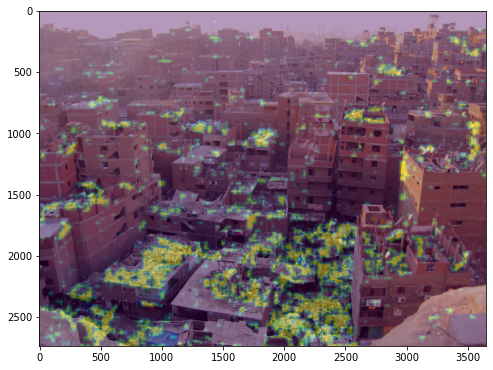

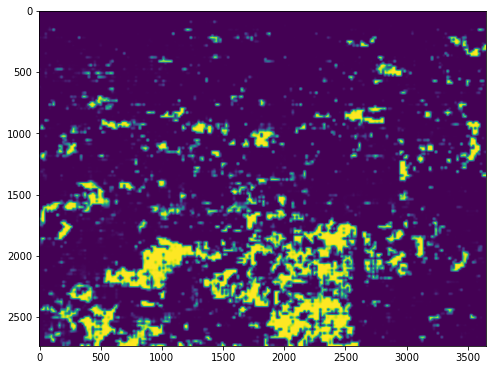

In [49]:
mask_garbage(DIR+'3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg', show=True, resize=False)

In [11]:
finp = tf.keras.layers.Input(shape=(320,320,3))

In [12]:
fmodel = tf.keras.models.Sequential([finp, model])

In [13]:
fmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, None, None, 1)     1086833   
Total params: 1,086,833
Trainable params: 1,074,721
Non-trainable params: 12,112
_________________________________________________________________


In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(fmodel)

In [15]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [1]:
# # For full integer quantization, you need to measure the dynamic range of activations and inputs by supplying
# # sample input data to the converter.
# def representative_dataset_gen():
#     for _ in range(num_calibration_steps):
#         # Get sample input data as a numpy array in a method of your choosing.
#         yield [input]
# converter.representative_dataset = representative_dataset_gen

In [16]:
converter.target_spec.supported_types = [tf.float32] # [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [ ]:
# Full integer for coral edge
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

In [17]:
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpzgdszzpm/assets


In [18]:
tflite_path = 'new_model/my_model_fp32.tflite'

In [19]:
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Steps to run are below

In [20]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_path)

In [21]:
tflite_interpreter.allocate_tensors()

In [22]:
tflite_input_details = tflite_interpreter.get_input_details()
tflite_input_details

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([ -1, 320, 320,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [23]:
tflite_output_details = tflite_interpreter.get_output_details()
tflite_output_details

[{'name': 'Identity',
  'index': 332,
  'shape': array([ 1, 20, 20,  1], dtype=int32),
  'shape_signature': array([-1, 20, 20,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [34]:
img = cv2.imread(DIR+'3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg')
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img = img/255#127.5 - 1

In [35]:
tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))

In [36]:
tflite_interpreter.invoke()

In [37]:
out = tflite_interpreter.get_tensor(tflite_output_details[0]['index'])

In [38]:
from time import time

In [ ]:
for i in range(100):
    start = time()
    tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))
    tflite_interpreter.invoke()
    out = tflite_interpreter.get_tensor(tflite_output_details[0]['index'])
    print(time()-start)

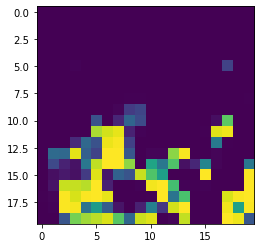

In [28]:
plt.imshow(out.squeeze())